In [1]:
from proteoscope.datamodule import ProteoscopeDataModule

In [2]:
pdm = ProteoscopeDataModule(
    images_path='/home/ec2-user/cytoself-data/images.zarr',
    labels_path='/home/ec2-user/cytoself-data/labels.csv',
    sequences_path='/home/ec2-user/cytoself-data/ESM_sequence_embeddings_full.zarr',
    num_workers=0,
    batch_size=16,
)
pdm.setup()

In [3]:
batch = next(iter(pdm.train_dataloader()))

In [4]:
print(batch['sequence_embed'].shape)
print(batch['image'].shape)

torch.Size([16, 1024, 1280])
torch.Size([16, 2, 100, 100])


In [5]:
import torch
from imagen_pytorch import Unet, Imagen

# unet for imagen

unet1 = Unet(
    dim = 32,
    cond_dim = 64,
    dim_mults = (1, 2, 4),
    num_resnet_blocks = 3,
    layer_attns = (False, True, True),
    layer_cross_attns = (False, True, True),
    cond_images_channels = 1,
    channels=1,
)

unet2 = Unet(
    dim = 32,
    cond_dim = 64,
    dim_mults = (1, 2, 4),
    num_resnet_blocks = (2, 4, 8),
    layer_attns = (False, False, True),
    layer_cross_attns = (False, False, True),
    cond_images_channels = 1,
    channels=1,
)

# imagen, which contains the unets above (base unet and super resoluting ones)

imagen = Imagen(
    unets = (unet1, unet2),
    image_sizes = (64, 100),
    timesteps = 20,
    cond_drop_prob = 0.1,
    channels=1,
    text_embed_dim=40,
).cuda()

The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/


In [6]:
# mock images (get a lot of this) and text encodings from large T5

seq_embeds = batch['sequence_embed'][:, :20, :40].cuda()
seq_mask = batch['sequence_mask'][:, :20].cuda()
images = batch['image'][:, 0, :, :].cuda()
images.unsqueeze_(dim=1)
cond_images = batch['image'][:, 1, :, :].cuda()
cond_images.unsqueeze_(dim=1)

print(images.shape)
print(cond_images.shape)
print(seq_embeds.shape)
print(seq_mask.shape)

torch.Size([16, 1, 100, 100])
torch.Size([16, 1, 100, 100])
torch.Size([16, 20, 40])
torch.Size([16, 20])


In [7]:
# feed images into imagen, training each unet in the cascade

for i in (1, 2):
    loss = imagen(images, text_embeds = seq_embeds, text_masks=seq_mask, cond_images = cond_images, unet_number = i)
    loss.backward()

# do the above for many many many many steps
# now you can sample an image based on the text embeddings from the cascading ddpm

output_images = imagen.sample(text_embeds=seq_embeds, text_masks=seq_mask, cond_images = cond_images, cond_scale = 3.)

output_images.shape # (3, 3, 256, 256)

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/20 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([16, 1, 100, 100])

In [8]:
import matplotlib.pyplot as plt

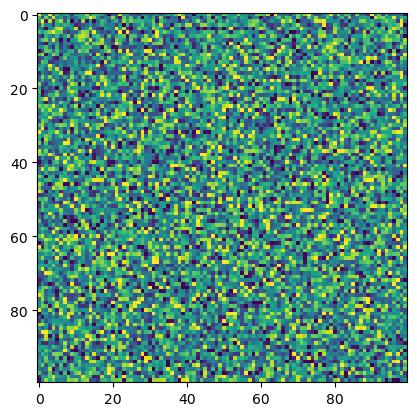

In [10]:
plt.imshow(output_images[0, 0].detach().cpu().numpy())